## ___8F: Implementing Platt Scaling to find P(Y==1|X)___

Check this <a href='https://drive.google.com/open?id=133odBinMOIVb_rh_GQxxsyMRyW-Zts7a'>PDF</a>
<img src='https://i.imgur.com/CAMnVnh.png'>



> 4. Apply SGD algorithm with ($f_{cv}$, $y_{cv}$) and find the weight $W$ intercept $b$ ```Note: here our data is of one dimensional so we will have a one dimensional weight vector i.e W.shape (1,)``` 

> Note1: Don't forget to change the values of $y_{cv}$ as mentioned in the above image. you will calculate y+, y- based on data points in train data

> Note2: the Sklearn's SGD algorithm doesn't support the real valued outputs, you need to use the code that was done in the `'Logistic Regression with SGD and L2'` Assignment after modifying loss function, and use same parameters that used in that assignment.
<img src='https://i.imgur.com/zKYE9Oc.png'>
if Y[i] is 1, it will be replaced with y+ value else it will replaced with y- value

> 5. For a given data point from $X_{test}$, $P(Y=1|X) = \frac{1}{1+exp(-(W*f_{test}+ b))}$ where ` `$f_{test}$ ```= decision_function(```$X_{test}$```)```, W and b will be learned as metioned in the above step


If any one wants to try other calibration algorithm istonic regression also please check these tutorials

1. http://fa.bianp.net/blog/tag/scikit-learn.html#fn:1

2. https://drive.google.com/open?id=1MzmA7QaP58RDzocB0RBmRiWfl7Co_VJ7

3. https://drive.google.com/open?id=133odBinMOIVb_rh_GQxxsyMRyW-Zts7a

In [1]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.svm import SVC

In [2]:
X, y = make_classification(n_samples = 5000, n_features = 5, n_redundant = 2, n_classes = 2, 
                           weights = [0.7], class_sep = 0.7, random_state = 15)

In [3]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 0)
Xcv, Xtest, ycv, ytest = train_test_split(Xtest, ytest, test_size = 0.25, random_state = 0)

print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)
print(Xtest.shape, ytest.shape, Xcv.shape, ycv.shape)

(4000, 5) (4000,) (250, 5) (250,)
(250, 5) (250,) (750, 5) (750,)


In [4]:
clf = SVC(kernel = "rbf", random_state = 0, decision_function_shape = 'ovo', C = 100, gamma = 0.001)

clf = clf.fit(Xtrain, ytrain)  # set the best parameters

pred = clf.predict(Xcv)

clf_decision = clf.decision_function(Xcv)

In [5]:
gamma = 0.001

In [6]:
def decision_function(clf, data):
    add_intercept = []

    for x_q in data:
        add_intercept.append(np.sum(clf.dual_coef_ * np.exp(-clf._gamma*np.sum((clf.support_vectors_ - x_q)**2, axis=1)))
                             + clf.intercept_[0])
    return add_intercept

fcv = decision_function(clf, Xcv)

print(fcv[:5], '\n', clf_decision[:5])

[-4.09306149139127, -3.1074169455995415, -0.1543106704656365, -3.4414738367657973, 1.8646927151322616] 
 [-4.09306149 -3.10741695 -0.15431067 -3.44147384  1.86469272]


In [7]:
unique, frequency = np.unique(ytrain, return_counts = True)  
count = np.asarray((unique, frequency))

print(count)

[[   0    1]
 [2818 1182]]


In [8]:
neg, pos = frequency[0], frequency[1]

def target_calib(x):
    cal_target = []
    for i in x:
        if i == 1:
            cal_target.append((pos + 1)/(pos + 2))
        elif i == 0:
            cal_target.append(1 / (neg + 2))
    return cal_target

calibrated_target = target_calib(pred.tolist())

In [9]:
def initialize_weights(dim):
    w = np.zeros_like((dim))
    b = np.zeros_like((1))
    print("Weights-Initialized : ", w.shape)
    return w, b

def sigmoid(z):
    sigmoid = 1/(1+math.exp(-z))
    return sigmoid

def logloss(W, b, X, Y):
    N = len(X)
    loss=[]
    for i in range(N):
        z = np.dot(X[i],W) + b
        pred = sigmoid(z)
        if pred < 0.5:
            l = (1-Y[i])*np.log10(1-pred)
            loss.append(l)
        else:
            l = Y[i]*np.log10(pred)
            loss.append(l)
    loss = (-1 * 1/len(loss) * sum(loss))
    return loss

def gradient_dw(x,y,w,b,alpha,N):
    dw = x*(y-sigmoid(np.dot(w,x)+b)) - alpha/N * w
    return dw

def gradient_db(x,y,w,b):
    db = (y-sigmoid(np.dot(w,x)+b))
    return db

def pred(w, b, X):
    N = len(X.tolist())
    predict = []
    for i in range(N):
        z = np.dot(X[i], w) + b
        predict.append(sigmoid(z))

    return np.array(predict)

In [10]:
def train(Y_calibrated,fcv,epochs,alpha,eta0):

    ''' In this function, we will implement logistic regression'''
    scale_down_factor = 0.0001
    epoch = 1
    w, b = initialize_weights(1)
    wl = []
    bl = []
    
    Lw = np.zeros_like(1)
    Lb = 0
    
    loss = 0
    prev = 0
    train_loss = []
    test_loss = []
    
    while epoch <= epochs:
        
        y_train_pred = []
        y_test_pred = []
        np.random.RandomState(seed=2)
        
        for m in range(len(Y_calibrated)):
            
            i = np.random.choice(len(Y_calibrated))
            z = np.dot(Y_calibrated[i],w) + b
            
            Lw = gradient_dw(Y_calibrated[i],fcv[i],w,b,alpha,len(Y_calibrated))
            Lb = gradient_db(Y_calibrated[i],fcv[i],w,b)
            
            w = (1-(alpha * scale_down_factor / epochs)) * w + alpha * Lw
            b = b + alpha * Lb
            
        train_loss.append(round(logloss(w,b,Y_calibrated, fcv), 3))
        
        if train_loss[-1] == prev:
            break;
        else:
            prev = train_loss[-1]
            print("Epoch: %d, train_Loss: %.3f" %(epoch, train_loss[-1]))
            epoch += 1
        
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.plot(train_loss, label='train_log_loss')
    plt.grid()
    plt.legend() 
    plt.title('Log loss vs epoch')
    plt.xlabel('epochs')
    plt.ylabel('log loss')
    plt.show()
        
    return w, b

Weights-Initialized :  ()
Epoch: 1, train_Loss: 0.597
Epoch: 2, train_Loss: 0.546
Epoch: 3, train_Loss: 0.497
Epoch: 4, train_Loss: 0.450
Epoch: 5, train_Loss: 0.408
Epoch: 6, train_Loss: 0.370
Epoch: 7, train_Loss: 0.334
Epoch: 8, train_Loss: 0.305
Epoch: 9, train_Loss: 0.279
Epoch: 10, train_Loss: 0.254
Epoch: 11, train_Loss: 0.232
Epoch: 12, train_Loss: 0.211
Epoch: 13, train_Loss: 0.193
Epoch: 14, train_Loss: 0.176
Epoch: 15, train_Loss: 0.161
Epoch: 16, train_Loss: 0.146
Epoch: 17, train_Loss: 0.133
Epoch: 18, train_Loss: 0.121
Epoch: 19, train_Loss: 0.111
Epoch: 20, train_Loss: 0.101
Epoch: 21, train_Loss: 0.091
Epoch: 22, train_Loss: 0.083
Epoch: 23, train_Loss: 0.076
Epoch: 24, train_Loss: 0.069
Epoch: 25, train_Loss: 0.062
Epoch: 26, train_Loss: 0.056
Epoch: 27, train_Loss: 0.051
Epoch: 28, train_Loss: 0.047
Epoch: 29, train_Loss: 0.043
Epoch: 30, train_Loss: 0.039
Epoch: 31, train_Loss: 0.035
Epoch: 32, train_Loss: 0.032
Epoch: 33, train_Loss: 0.029
Epoch: 34, train_Loss: 0.0

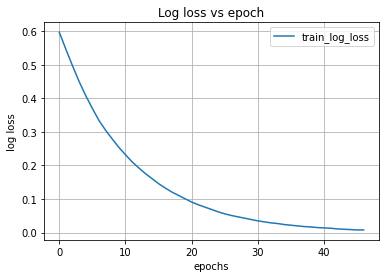

In [11]:
alpha = 0.0001
eta0 = 0.0001
N = len(Xcv)
epochs = 50

w, b = train(calibrated_target, fcv, epochs, alpha, eta0)

In [12]:
w, b

(1.3341411444161075, -4.6243179289105925)

In [13]:
f_test = decision_function(clf, Xtest)

def calibrated_test(ftest, weight, bias):
    test_prediction = []
    for i in ftest:
        z = np.dot(i,weight) + bias
        test_prediction.append(sigmoid(z))
    return np.array(test_prediction)
test_pred = calibrated_test(f_test, w, b)

print(test_pred[:10])

[3.59581024e-04 5.96159150e-02 1.95469816e-02 3.56131596e-01
 8.77207874e-04 5.41889188e-04 2.63292442e-02 6.22307716e-04
 8.51091889e-05 2.48221281e-04]
